# Importing ODL geometries

This demo describes how to import ODL geometries. 

This demo requires the following packages (replace `<X.X>` with your currently installed CUDA version):

```sh
conda install pytorch cudatoolkit=<X.X>  astra-toolbox matplotlib tqdm -c astra-toolbox/label/dev -c pytorch
pip install git+https://github.com/ahendriksen/tomosipo.git@WIP-odl
# Install the latest version of ODL
pip install git+https://github.com/odlgroup/odl
```
Note that this demo requires the `WIP-odl` branch of tomosipo to be installed at the moment. 


In [1]:
import odl
import torch 
import tomosipo as ts
import tomosipo.torch_support
import matplotlib.pyplot as plt
import numpy as np
from tomosipo.odl import (
    from_odl,
    discretized_space_2d_to_3d,
    parallel_2d_to_3d_geometry,
    fan_to_cone_beam_geometry,
)

def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        # Remove ticks, splines
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ax.spines.values():
            s.set_visible(False)
        
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu().numpy()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()

# 2D fanbeam geometry

This example shows how to convert a 2D fanbeam geometry from ODL. 
In the process, the geometry is first converted to 3D, since tomosipo supports only 3D geometries.

Note that the shape of the sinogram data is different (angle dimension comes first in ODL, in the middle in ASTRA/tomosipo). 
Otherwise, there are no differences between the tomosipo and ODL operators (and their adjoint/transpose).

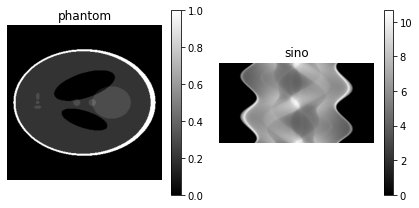

In [2]:
# Create 2D reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], 
    max_pt=[20, 20], 
    shape=[300, 300],
    dtype='float32'
)

# Create 2D fanbeam geometry from reconstruction space:
geometry = odl.tomo.cone_beam_geometry(reco_space, 40, 40, 360)
# Create 2D projection operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')

# Forward project a shepp-logan phantom.
phantom = odl.phantom.shepp_logan(reco_space, modified=True)
proj_data = ray_trafo(phantom)

plot_imgs(phantom=phantom.data, sino=proj_data.data)

In [3]:
vg_odl = discretized_space_2d_to_3d(reco_space)
pg_odl = fan_to_cone_beam_geometry(geometry)
A_odl = odl.tomo.RayTransform(vg_odl, pg_odl, impl='astra_cuda')

vg = from_odl(reco_space)
pg = from_odl(geometry)
A_ts = ts.operator(vg, pg)

                tomosipo      | ODL
------------------------------+--------------
Sinogram shape: (1, 360, 695) | (360, 1, 695)
Volume shape:   (1, 300, 300) | (1, 300, 300)


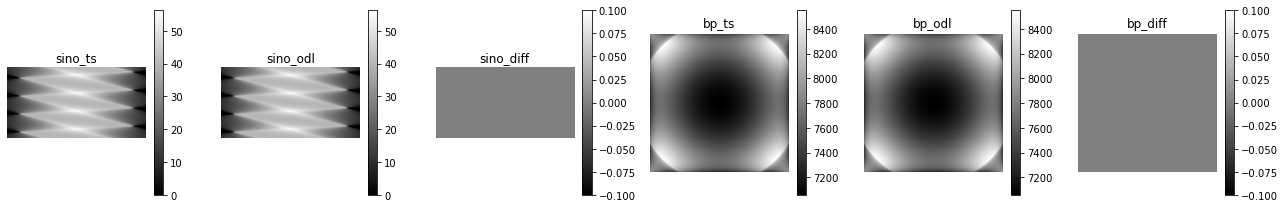

In [10]:
x = np.ones(A_ts.domain_shape, dtype=np.float32)
y_ts = A_ts(x)
y_odl = A_odl(x).data

bp_ts = A_ts.T(y_ts)
bp_odl = A_odl.adjoint(y_odl).data
print("                tomosipo      | ODL")
print("------------------------------+--------------")
print(f"Sinogram shape: {y_ts.shape} | {y_odl.shape}")
print(f"Volume shape:   {bp_ts.shape} | {bp_odl.shape}")
plot_imgs(
    sino_ts=y_ts[0],
    sino_odl=y_odl[:, 0, :],
    sino_diff=y_ts[0] - y_odl[:, 0],
    bp_ts=bp_ts,
    bp_odl=bp_odl,    
    bp_diff=bp_ts - bp_odl,
)